# Classifying Hate Speech in Twitter

In [3]:
import os
os.chdir('/Users/akiratachibana/Downloads/Classes/ECON4763/Project')

import numpy as np
import pandas as pd
import math
from sklearn import model_selection, preprocessing, metrics, linear_model, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import make_pipeline
import pandas as pd, numpy, string
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import math
def truncate(number, digits) -> float:
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper

import snscrape.modules.twitter as sntwitter
import re

from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.ensemble import GradientBoostingClassifier as GB

#pipeline
from numpy import where
from matplotlib import pyplot

#Resampling_Pipeline function
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import TfidfVectorizer 

train = pd.read_csv('hate_dataset.csv')
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


## Preparing Train and Test Data

In [4]:
#data cleaning
porter=PorterStemmer()
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    words = tok.tokenize(lower_case)
    #Stemming
    stem_sentence=[]
    for word in words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    words="".join(stem_sentence).strip()
    return words

nums = [0,len(train)]
clean_tweet_texts = []
for i in range(nums[0],nums[1]):
    clean_tweet_texts.append(tweet_cleaner(train['tweet'][i]))

    
train_clean = pd.DataFrame(clean_tweet_texts,columns=['tweet'])
train_clean['label'] = train.label
train_clean['id'] = train.id



In [5]:
#split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(train_clean['tweet'],train_clean['label'])

#label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=100000,stop_words='english')
tfidf_vect.fit(train_clean['tweet'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [6]:
#Percentage of Positive/Negative, before oversampling
print("Positive: ", train.label.value_counts()[0]/len(train)*100,"%")
print("Negative: ", train.label.value_counts()[1]/len(train)*100,"%")

print("Positive: ", train.label.value_counts()[0])
print("Negative: ", train.label.value_counts()[1])

Positive:  92.98542018647143 %
Negative:  7.014579813528565 %
Positive:  29720
Negative:  2242


## Oversampling Minority Class Using SMOTE

In [7]:
oversample = SMOTE()
xtrain_tfidf, train_y = oversample.fit_resample(xtrain_tfidf, train_y)

In [8]:
#Testing data proportion after SMOTE oversampling
positive = 0
negative = 0

for n in train_y:
    if n == 0:
        positive = positive + 1
    elif n == 1:
        negative = negative + 1

print("Positive =", (positive/(positive+negative))*100,"%, ",positive,"observations.")
print("Negative =", (negative/(positive+negative))*100,"%, ",negative,"observations.")

Positive = 50.0 %,  22287 observations.
Negative = 50.0 %,  22287 observations.


## Optimizing KNNC, SVC, NB, RF, and GB to Fit Our Model

### K-Nearest Neighbors

In [12]:
#Tuning KNNC n_neighbors using GridSearchCV
count = 0
KNNCscorearray = [1,2,3,4,5,6,7,8,9,10]

tuned_parameters = {'n_neighbors': KNNCscorearray}


print("# Tuning for f1_micro")

clf = GridSearchCV(KNNC(), tuned_parameters, cv=3, scoring='f1_micro').fit(xtrain_tfidf, train_y)

print("Best parameters set found on KNNC train set: ")
print(clf.best_params_)
print("\nGrid scores on KNNC train set:\n")

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
          % (mean, std * 2, params))
    KNNCres = KNNC(n_neighbors = KNNCscorearray[count]).fit(xtrain_tfidf, train_y)
    KNNCscorearray[count] = KNNCres.score(xvalid_tfidf,valid_y)
    count=count+1

print("\nClassification Report:\n")
print(classification_report(valid_y, clf.predict(xvalid_tfidf)))

# Tuning for f1_micro
Best parameters set found on KNNC train set: 
{'n_neighbors': 2}

Grid scores on KNNC train set:

0.640 (+/-0.009) for {'n_neighbors': 1}
0.645 (+/-0.009) for {'n_neighbors': 2}
0.596 (+/-0.006) for {'n_neighbors': 3}
0.596 (+/-0.006) for {'n_neighbors': 4}
0.580 (+/-0.005) for {'n_neighbors': 5}
0.581 (+/-0.005) for {'n_neighbors': 6}
0.573 (+/-0.003) for {'n_neighbors': 7}
0.574 (+/-0.004) for {'n_neighbors': 8}
0.567 (+/-0.006) for {'n_neighbors': 9}
0.568 (+/-0.005) for {'n_neighbors': 10}

Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.34      0.51      7430
           1       0.10      0.97      0.18       561

    accuracy                           0.39      7991
   macro avg       0.55      0.66      0.34      7991
weighted avg       0.93      0.39      0.48      7991



Text(0.5, 1.0, 'KNNC Optimized Neighbors')

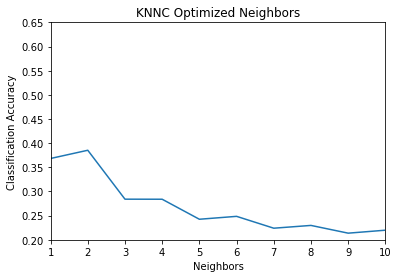

In [13]:
#Visualizing KNN by score
neighbors = [1,2,3,4,5,6,7,8,9,10]

plt.plot(neighbors, KNNCscorearray)
plt.xlim(1,10)
plt.ylim(0.2,0.65)

plt.ylabel('Classification Accuracy')
plt.xlabel('Neighbors')
plt.title('KNNC Optimized Neighbors')

In [ ]:
import winsound
duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

### Support Vector Machine

In [14]:
#Support Vector Machine tuning C
count = 0
SVCscorearray = [1, 10, 100, 1000]

tuned_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'], 'C': SVCscorearray}
                    


print("# Tuning for f1_micro\n")

clf = GridSearchCV(SVC(), tuned_parameters, cv=3, scoring='f1_micro').fit(xtrain_tfidf, train_y)

print("Best parameters set found on train set: ")
print(clf.best_params_)
print("\nGrid scores on train set:\n")
    
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
print("\nClassification Report:\n")
print(classification_report(valid_y, clf.predict(xvalid_tfidf)))

winsound.Beep(523, 1000)
winsound.Beep(784, 1000)
winsound.Beep(659, 1000)

# Tuning for f1_micro
Best parameters set found on train set: 
{'C': 10, 'kernel': 'rbf'}

Grid scores on train set:

0.942 (+/-0.002) for {'C': 1, 'kernel': 'linear'}
0.710 (+/-0.030) for {'C': 1, 'kernel': 'poly'}
0.986 (+/-0.032) for {'C': 1, 'kernel': 'rbf'}
0.933 (+/-0.003) for {'C': 1, 'kernel': 'sigmoid'}
0.951 (+/-0.003) for {'C': 10, 'kernel': 'linear'}
0.685 (+/-0.011) for {'C': 10, 'kernel': 'poly'}
0.997 (+/-0.001) for {'C': 10, 'kernel': 'rbf'}
0.923 (+/-0.009) for {'C': 10, 'kernel': 'sigmoid'}
0.950 (+/-0.003) for {'C': 100, 'kernel': 'linear'}
0.685 (+/-0.011) for {'C': 100, 'kernel': 'poly'}
0.997 (+/-0.000) for {'C': 100, 'kernel': 'rbf'}
0.917 (+/-0.020) for {'C': 100, 'kernel': 'sigmoid'}
0.948 (+/-0.004) for {'C': 1000, 'kernel': 'linear'}
0.685 (+/-0.011) for {'C': 1000, 'kernel': 'poly'}
0.996 (+/-0.000) for {'C': 1000, 'kernel': 'rbf'}
0.912 (+/-0.026) for {'C': 1000, 'kernel': 'sigmoid'}

Classification Report:

              precision    recall  f1-score   sup

Text(0.5, 1.0, 'SVC Tuning C')

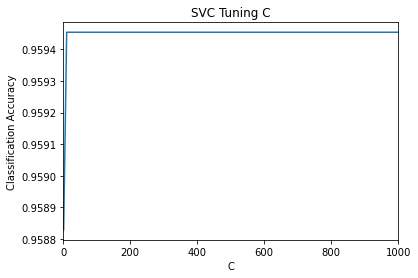

In [75]:
#Visualizing SVC
neighbors = [1,10,100,1000]

plt.plot(neighbors, SVCscorearray)
plt.xlim(0,1000)

plt.ylabel('Classification Accuracy')
plt.xlabel('C')
plt.title('SVC Tuning C')

### Multinomial Naive Bayes

In [9]:
#Multinomial Naive Bayes tuning alpha
from sklearn.naive_bayes import MultinomialNB as NB
from sklearn.model_selection import GridSearchCV

array = np.arange(1,100)
finegrid = 0.00001*np.arange(500)

NBscorearray = finegrid

count = 0

tuned_parameters = {'alpha': NBscorearray[1:]}

print("# Tuning for f1_micro")

clf = GridSearchCV(NB(), tuned_parameters, cv=5, scoring='f1_micro').fit(xtrain_tfidf, train_y)

print("Best parameters set found on train set: ")
print(clf.best_params_)
print("\nGrid scores on train set:\n")
    
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    
    count = count+1
                     
print("\nClassification Report:\n")
print(classification_report(valid_y, clf.predict(xvalid_tfidf)))


# Tuning for f1_micro
Best parameters set found on train set: 
{'alpha': 1e-05}

Grid scores on train set:

0.963 (+/-0.006) for {'alpha': 1e-05}
0.963 (+/-0.006) for {'alpha': 2e-05}
0.963 (+/-0.006) for {'alpha': 3.0000000000000004e-05}
0.963 (+/-0.006) for {'alpha': 4e-05}
0.963 (+/-0.006) for {'alpha': 5e-05}
0.963 (+/-0.006) for {'alpha': 6.000000000000001e-05}
0.963 (+/-0.006) for {'alpha': 7.000000000000001e-05}
0.963 (+/-0.006) for {'alpha': 8e-05}
0.963 (+/-0.006) for {'alpha': 9e-05}
0.963 (+/-0.006) for {'alpha': 0.0001}
0.963 (+/-0.006) for {'alpha': 0.00011}
0.963 (+/-0.006) for {'alpha': 0.00012000000000000002}
0.963 (+/-0.006) for {'alpha': 0.00013000000000000002}
0.963 (+/-0.006) for {'alpha': 0.00014000000000000001}
0.963 (+/-0.006) for {'alpha': 0.00015000000000000001}
0.963 (+/-0.006) for {'alpha': 0.00016}
0.963 (+/-0.006) for {'alpha': 0.00017}
0.963 (+/-0.006) for {'alpha': 0.00018}
0.963 (+/-0.006) for {'alpha': 0.00019}
0.963 (+/-0.006) for {'alpha': 0.0002}
0.9

Text(0.5, 1.0, 'Naive Bayes Tuning Alpha')

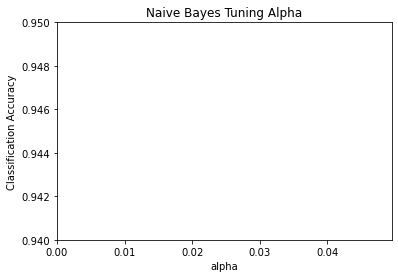

In [8]:
import matplotlib.pyplot as plt

array = np.arange(1,100)
finegrid = 0.0001*np.arange(500)

plt.plot(finegrid, NBscorearray)
plt.xlim(0,0.0495)
plt.ylim(0.94,0.95)

plt.ylabel('Classification Accuracy')
plt.xlabel('alpha')
plt.title('Naive Bayes Tuning Alpha')

In [10]:
#Top hate speech classifiers based on tuned Naive Bayes
NBres = NB(alpha = 0.00001).fit(xtrain_tfidf, train_y)

HateSpeechSorted = NBres.feature_log_prob_[0, :].argsort()[::-1]
NotHateSpeechSorted = NBres.feature_log_prob_[1, :].argsort()[::-1]

print(np.take(tfidf_vect.get_feature_names(), HateSpeechSorted[:10]))
print(np.take(tfidf_vect.get_feature_names(), NotHateSpeechSorted[:10]))

['love' 'day' 's' 'thank' 'thi' 'happi' 't' 'posit' 'u' 'time']
['libtard' 'trump' 'black' 'polit' 'white' 'liber' 's' 'sjw' 'like'
 'retweet']


C:\Users\mikha\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [30]:
train_clean.shape

(31962, 3)

### Random Forest

In [33]:
#Random Forest, optimizing n_estimators

count = 0
n_features = train_clean.shape[0]

estimators = [25,50,75,100]
RFscorearray = [0]*4

tuned_parameters = {'n_estimators': estimators}

print("# Tuning for f1_micro\n")

clf = GridSearchCV(RF(n_estimators=1000, max_depth=None, max_features = math.floor(math.sqrt(n_features)), min_samples_split = 2), tuned_parameters,cv=3, scoring='f1_micro').fit(xtrain_tfidf, train_y)

print("Best parameters set found on train set: ")
print(clf.best_params_)
print("\nGrid scores on train set:\n")
    
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    RFcalc = RF(n_estimators=estimators[count], max_depth=None, max_features=math.floor(math.sqrt(n_features)), min_samples_split = 2)
    RFres = RFcalc.fit(xtrain_tfidf, train_y)
    RFscorearray[count] = RFres.score(xvalid_tfidf, valid_y)
    count=count+1
                     
print("\nClassification Report:\n")
print(classification_report(valid_y, clf.predict(xvalid_tfidf)))

# Tuning for f1_micro

Best parameters set found on train set: 
{'n_estimators': 50}

Grid scores on train set:

0.977 (+/-0.002) for {'n_estimators': 25}
0.981 (+/-0.002) for {'n_estimators': 50}
0.980 (+/-0.004) for {'n_estimators': 75}
0.980 (+/-0.003) for {'n_estimators': 100}

Classification Report:

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      7430
           1       0.64      0.66      0.65       561

    accuracy                           0.95      7991
   macro avg       0.81      0.82      0.81      7991
weighted avg       0.95      0.95      0.95      7991



In [147]:
RFscorearray

[0.953072206232011, 0.9544487548492053, 0.9533224877987736, 0.9539481917156801]

In [150]:
RFcalc = RF(n_estimators=120, max_depth=None, max_features=math.floor(math.sqrt(n_features)), min_samples_split = 2)
RFres = RFcalc.fit(xtrain_tfidf, train_y)
print(RFres.score(xvalid_tfidf, valid_y))

0.953072206232011


### Gradient Boosting

In [34]:
#Gradient Boosting, optimizing n_estimators

count = 0

GBestimators = [1000, 5000, 10000]
GBscorearray = [0]*3

tuned_parameters = {'n_estimators': GBestimators}

print("# Tuning for fl_micro\n")

clf = GridSearchCV(GB(n_estimators=n, learning_rate=0.1, max_depth=2), 
                   tuned_parameters,cv=3, scoring='f1_micro').fit(xtrain_tfidf, train_y)

print("Best parameters set found on train set: ")
print(clf.best_params_)
print("\nGrid scores on train set:\n")
    
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
        
    GBcalc = GB(n_estimators=GBestimators[count], learning_rate=0.1, max_depth=2)
    GBres = GBcalc.fit(xtrain_tfidf, train_y)
    GBscorearray[count] = GBres.score(xvalid_tfidf, valid_y)
    count=count+1
                     
print("\nClassification Report:\n")
print(classification_report(valid_y, clf.predict(xvalid_tfidf)))

# Tuning for fl_micro

Best parameters set found on train set: 
{'n_estimators': 10000}

Grid scores on train set:

0.929 (+/-0.018) for {'n_estimators': 1000}
0.971 (+/-0.010) for {'n_estimators': 5000}
0.975 (+/-0.006) for {'n_estimators': 10000}

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.97      0.98      7430
           1       0.68      0.73      0.70       561

    accuracy                           0.96      7991
   macro avg       0.83      0.85      0.84      7991
weighted avg       0.96      0.96      0.96      7991



In [158]:
GBscorearray

[0.9428106619947441,
 0.9443123513953198,
 0.9454386184457515,
 0.9501939682142411]

1. trump (0.009604)
2. polit (0.009452)
3. liber (0.008127)
4. racist (0.007959)
5. libtard (0.007803)
6. white (0.007722)
7. sjw (0.007333)
8. allahsoil (0.007131)
9. black (0.006304)
10. s (0.004860)


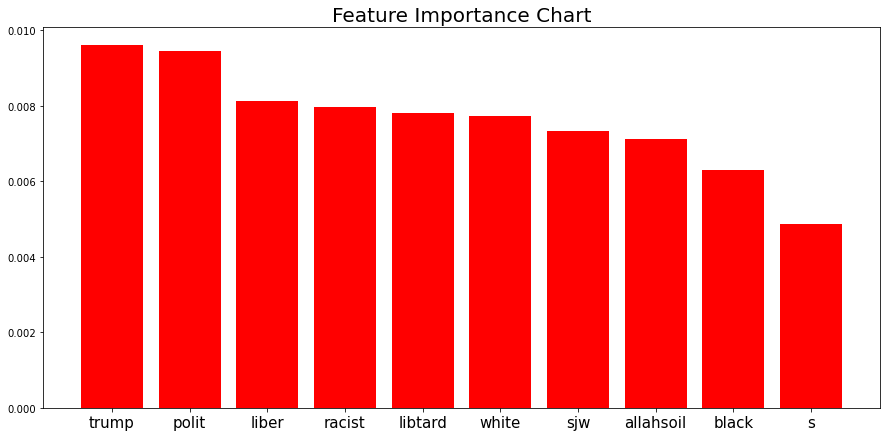

In [162]:
#Important Feature results from RF
RFcalc = RF(n_estimators=125, max_depth=None, max_features=math.floor(math.sqrt(n_features)), min_samples_split = 2)
RFres = RFcalc.fit(xtrain_tfidf, train_y)
importances = RFres.feature_importances_ 

top10v = np.sort(importances)[-10:][::-1] 
top10n = np.argsort(importances)[-10:][::-1] 

feature_names = np.asarray(tfidf_vect.get_feature_names()) 

for f in range(10):
    print("%d. %s (%f)" % (f + 1, feature_names[top10n[f]], top10v[f]))

plt.figure(figsize=(15,7))
plt.title("Feature Importance Chart",  fontsize=20)
plt.bar(feature_names[top10n], top10v, color="r")
plt.xticks(fontsize= 15)
plt.show()

# Summary of Model Optimization and Selection

First step: data was cleaned of bad text, links, unnecessary spaces, and anything else that wasn't necessary.
Second, the clean data was split into training and test data by train_test_split.
This turned train_x and valid_x into trainx_tfidf and validx_tfidf
The train_x and valid_x (tweet content) were vectorized by word. stop_words were a generic English list for now.

We determined that the best fitting synthetic oversampling algorithm for our project is SMOTE.
xtrain_tfidf and train_y were oversampled via oversample.fit_resample().
The proportion of hate speech vs not hate speech was tested after the oversampling.
After oversampling, the two new training sets had an equal proportion of hate speech vs not. Success!

For each algorithm, we decided to score using recall to minimize Type II errors.


kNN was tuned to n_neighbors using GridSearchCV.
The optimal n_neighbors value was calculated to be 2 with a classification score of 0.941934676511075.
A graph was created to show relationship between n_neighbors and classification accuracy.

SVC was tuned by C value for four kernels: rbf, linear, sigmoid, and poly. The optimal combination was C=10 with the rbf kernel, with a classification accuracy of 0.9624577649856088.
A graph was created to show relationship between C and classification accuracy.

Multinominal Naive Bayes was tuned to the alpha parameter using a fine grid in GridSearchCV.
Optimal alpha value was calculated to be 0.0088 with a classification accuracy of 0.9449380553122263.
A graph was created to show relationship between alpha and classification accuracy.
Using these results, we calculated the top 10 words by weight for each classification, as follows:
Not Hate Speech: ['love' 'day' 's' 'thank' 'thi' 'happi' 't' 'posit' 'u' 'time']
Hate Speech: ['libtard' 'trump' 'white' 'black' 's' 't' 'like' 'thi' 'racist' 'liber']

Random Forest was optimized by n_estimators using GridSearchCV.
Because of the time RF takes to process, I haven't found a precise value for n_estimators yet.
I know that the optimal value is between 120 and 130.
125 n_neighbors has been the highest scoring so far, with a classification accuracy of 0.9544487548492053.

Gradient Boosting was optimized by n_estimators using GridSearchCV.
Because of the time GB takes to process, I haven't found a precise value for n_estimators yet.
I know that the optimal value is probably above 300.

Best recall scores:

kNN : 0.772 (+/-0.008) for {'n_neighbors': 2}

SVC : 0.997 (+/-0.001) for {'C': 10, 'kernel': 'rbf'} 

NB  : 0.794 (+/-0.022) for {'alpha': 0.0088}

RF  : 0.292 (+/-0.026) for {'n_estimators': 125}

GB  : took too long

Best classification accuracies:

kNN : 0.9419, n_neighbors = 2

SVC : 0.9625, C = 10

NB  : 0.9449, alpha = 0.0088

RF  : 0.9544, n_estimators = 125

GB  : 0.9502, n_estimators = 300


Overall, Support Vector Machine with a C of 10 and rbf kernel scored the highest recall and classification score. Therefore, it will be our selected model for hate speech identification. This makes sense in our training data because we had far more features than we did observations, so naturally SVM performed the best because that is its specialty. 

# Using Selected Model On New Data

In [7]:
# Saving model in SVCres
SVCres = SVC(kernel='rbf',C=10).fit(xtrain_tfidf, train_y)

## Preselected Data (Trump Tweets)

In [26]:
# Testing model on Donald Trump tweets

test = pd.read_csv("realdonaldtrump.csv")
trumptest_x = test.iloc[:,2]
trumptest_x

0        Be sure to tune in and watch Donald Trump on L...
1        Donald Trump will be appearing on The View tom...
2        Donald Trump reads Top Ten Financial Tips on L...
3        New Blog Post: Celebrity Apprentice Finale and...
4        "My persona will never be that of a wallflower...
                               ...                        
43347    Joe Biden was a TOTAL FAILURE in Government. H...
43348    Will be interviewed on @ seanhannity tonight a...
43349                           pic.twitter.com/3lm1spbU8X
43350                           pic.twitter.com/vpCE5MadUz
43351                           pic.twitter.com/VLlc0BHW41
Name: content, Length: 43352, dtype: object

In [27]:
#Vectorizing Trump's tweets
tfidf_vect.fit(train_clean['tweet'])
trumptestx_tfidf = tfidf_vect.transform(trumptest_x)
trumptestx_tfidf.shape

(43352, 31216)

In [29]:
#Determine percentage of hate speech in Trump's tweets using model
predict = SVCres.predict(trumptestx_tfidf)
positive = 0
negative = 0

for n in predict:
    if n == 0:
        positive = positive+1
    if n == 1:
        negative = negative+1

print("username: realDonaldTrump")

print("\nTotal observations:",positive+negative)        
print("Total not hate speech:",positive,"observations.")
print("Total hate speech:",negative,"observations.")

print("\nTotal not hate speech:",truncate((positive/(positive+negative))*100,3),"% not hate speech.")
print("Total hate speech:",truncate((negative/(positive+negative))*100,3),"% hate speech.")

username: realDonaldTrump

Total observations: 43352
Total not hate speech: 41719 observations.
Total hate speech: 1633 observations.

Total not hate speech: 96.233 % not hate speech.
Total hate speech: 3.766 % hate speech.


In [17]:
#function to enter username, number of tweets and our model determines proportion of hate speech vs not.
def hate_speech_identifier(username,numtweets=100):
    tweets_list = []
    name = 'from:' + username

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(name).get_items()):
        if i>=numtweets:
            break
        tweets_list.append([tweet.content])
    
    tweets_df = pd.DataFrame(tweets_list, columns=['tweet'])

    testx = tweets_df.iloc[:,0]
    tfidf_vect.fit(train_clean['tweet'])
    testx_tfidf = tfidf_vect.transform(testx)
    

    predict = SVCres.predict(testx_tfidf)
    positive = 0
    negative = 0

    for n in predict:
        if n == 0:
            positive = positive+1
        if n == 1:
            negative = negative+1
    
    print("username:",username)
    
    print("\nTotal observations:",positive+negative)        
    print("Total not hate speech:",positive,"observations.")
    print("Total hate speech:",negative,"observations.")
    
    print("\nTotal not hate speech:",truncate((positive/(positive+negative))*100,3),"% not hate speech.")
    print("Total hate speech:",truncate((negative/(positive+negative))*100,3),"% hate speech.")

In [46]:
#returns array of predicted tweets
def hs_tester(username,numtweets=1000):
    tweets_list = []
    name = 'from:' + username

    for i,tweet in enumerate(sntwitter.TwitterSearchScraper(name).get_items()):
        if i>=numtweets:
            break
        tweets_list.append([tweet.content])
    
    tweets_df = pd.DataFrame(tweets_list, columns=['tweet'])

    testx = tweets_df.iloc[:,0]
    tfidf_vect.fit(train_clean['tweet'])
    testx_tfidf = tfidf_vect.transform(testx)
    

    predict = SVCres.predict(testx_tfidf)
    positive = 0
    negative = 0

    for n in predict:
        if n == 0:
            positive = positive+1
        if n == 1:
            negative = negative+1
        
    return negative/(negative+positive)

In [15]:
hate_speech_identifier('DonaldJTrumpJr',1000)

username: DonaldJTrumpJr

Total observations: 1000
Total not hate speech: 970 observations.
Total hate speech: 30 observations.

Total not hate speech: 97.0 % not hate speech.
Total hate speech: 3.0 % hate speech.


In [15]:
hate_speech_identifier('TheEllenShow',1000)

username: TheEllenShow

Total observations: 10000
Total not hate speech: 9613 observations.
Total hate speech: 387 observations.

Total not hate speech: 96.13 % not hate speech.
Total hate speech: 3.869 % hate speech.


In [25]:
hate_speech_identifier('pokimanelol',1000)

username: pokimanelol

Total observations: 1000
Total not hate speech: 834 observations.
Total hate speech: 166 observations.

Total not hate speech: 83.399 % not hate speech.
Total hate speech: 16.6 % hate speech.


In [24]:
test = ['DonaldJTrumpJr','GOP','Pokimanelol','TheEllenShow']
array =[]
for acc in test:
    array.append(hs_tester(acc))
    
print(array)

[0.03, 0.03, 0.164, 0.017]


In [47]:
#Testing classification rates for all US Senators (116th Congress)
test = ['lisamurkowski','SenDanSullivan','SenDougJones','SenShelby','JohnBoozman','SenTomCotton',
        'SenatorSinema','SenFeinstein','SenatorBennet','SenCoryGardner','SenBlumenthal',
        'SenMurphyOffice','SenatorCarper','ChrisCoons','SenRubioPress','SenRickScott','sendavidperdue',
        'maziehirono','SenBrianSchatz','SenJoniErnst','ChuckGrassley','MikeCrapo','SenatorRisch','SenDuckworth',
        'SenatorDurbin','SenatorBraun','SenToddYoung','JerryMoran','SenPatRoberts','LeaderMcconnell','RandPaul',
        'SenBillCassidy','SenJohnKennedy','SenMarkey','SenWarren','SenatorCardin','ChrisVanHollen','SenatorCollins',
        'SenAngusKing','SenGaryPeters','SenStabenow','SenAmyKlobuchar','SenTinaSmith','RoyBlunt','SenHawleyPress',
        'SenHydeSmith','SenatorWicker','SteveDaines','SenatorTester','SenatorBurr','SenThomTillis','SenKevinCramer',
        'SenJohnHoeven','SenatorFischer','SenSasse','SenatorHassan','SenatorShaheen','SenBooker','SenatorMenendez',
        'MartinHeinrich','SenatorTomUdall','SenCortezMasto','SenJackyRosen','gillibrandny','SenSchumer','SenSherrodBrown',
        'senrobportman','JimInhofe','SenatorLankford','SenJeffMerkley','RonWyden','SenBobCasey','SenToomey','SenJackReed',
        'SenWhiteHouse','LindseyGrahamSC','SenatorTimScott','SenatorRounds','SenJohnThune','SenAlexander',
        'MarshaBlackburn','JohnCornyn','SenTedCruz','SenMikeLee','SenatorRomney','MarkWarner','SenatorLeahy',
        'SenSanders','SenatorCantwell','PattyMurray','SenatorBaldwin','SenRonJohnson','SenCapito','Sen_JoeManchin',
        'SenJohnBarrasso','SenatorEnzi']

#Senators with no accounts: SenMcSallyAZ, SenatorIsakon

SenatorScores =[]
for acc in test:
    score = hs_tester(acc)
    SenatorScores.append(score)
    print('username:',acc,'score:',score)
    
average = sum(SenatorScores)/(len(SenatorScores)+1)

username: lisamurkowski score: 0.004
username: SenDanSullivan score: 0.007
username: SenDougJones score: 0.009
username: SenShelby score: 0.003
username: JohnBoozman score: 0.008
username: SenTomCotton score: 0.03
username: SenatorSinema score: 0.015
username: SenFeinstein score: 0.015
username: SenatorBennet score: 0.011
username: SenCoryGardner score: 0.005
username: SenBlumenthal score: 0.002
username: SenMurphyOffice score: 0.018
username: SenatorCarper score: 0.009
username: ChrisCoons score: 0.005
username: SenRubioPress score: 0.007
username: SenRickScott score: 0.006
username: sendavidperdue score: 0.007
username: maziehirono score: 0.055
username: SenBrianSchatz score: 0.01
username: SenJoniErnst score: 0.002
username: ChuckGrassley score: 0.004
username: MikeCrapo score: 0.004
username: SenatorRisch score: 0.005
username: SenDuckworth score: 0.026
username: SenatorDurbin score: 0.012
username: SenatorBraun score: 0.016
username: SenToddYoung score: 0.012
username: JerryMoran 

In [58]:
#Creating DataFrame for scores
df_SenScores = pd.DataFrame({'Senator' : test, 'Score' : SenatorScores})
df_SenScores.head()

,Senator,Score
0,lisamurkowski,0.004
1,SenDanSullivan,0.007
2,SenDougJones,0.009
3,SenShelby,0.003
4,JohnBoozman,0.008


In [59]:
df_SenScores.describe()

,Score
count,96.000000
mean,0.011822
std,0.008464
min,0.002000
25%,0.006672
50%,0.010000
75%,0.015000
max,0.055000


In [62]:
hate_speech_identifier('GOP',10000)
print()
hate_speech_identifier('TheDemocrats',10000)

username: GOP

Total observations: 10000
Total not hate speech: 9762 observations.
Total hate speech: 238 observations.

Total not hate speech: 97.619 % not hate speech.
Total hate speech: 2.38 % hate speech.

username: TheDemocrats

Total observations: 10000
Total not hate speech: 9624 observations.
Total hate speech: 376 observations.

Total not hate speech: 96.24 % not hate speech.
Total hate speech: 3.76 % hate speech.


Of 96 US Senators' last 1000 tweets, the mean classification rate for hate speech was 1.18% with a standard deviation of 0.85%. On average, US Senators send a tweet containing hate speech content approximately 1 in every 100 tweets. This is considerably lower than rates of GOP and TheDemocrats, the two biggest entities for Republicans and Democrats respectively.